In [1]:
# Get all the apks' VirusTotal report, saved as `vt_reports.json`

import pandas as pd
import requests
import logging
import time
import json

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
)
logging.info(f"Init")

df = pd.read_excel('./Mobile Apps.xlsx', sheet_name='hash')
hash_all = df['SHA-256'].to_list()

hash_done = set()
try:
    with open('./vt_reports.json', 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()
        for line in lines:
            result = json.loads(line)
            hash_done.add(result['data']['attributes']['sha256'])
except Exception as e:
    logging.warning(f"Got an exception {type(e)}: {e}")
    
hash_todo = set(hash_all) - hash_done
logging.info(f"Among {len(hash_all)} hash values, {len(hash_todo)} VT reports are left to be crawled.")


headers = {
    "accept": "application/json",
    "x-apikey": "edf1416114b5280a8a5b0a55c906fbd2470974896933eb0a13fd9fccb7b3ab5d"
}

vt_count = 0
with open('./vt_reports.json','a',encoding='utf-8') as f:
    for hash in hash_todo:
        try:
            url = f"https://www.virustotal.com/api/v3/files/{hash}"
            response = requests.get(url, headers=headers)
            f.write(json.dumps(response.json())+'\n')
            vt_count += 1
            time.sleep(20)
        except Exception as e:
            logging.warning(f"Got an exception {type(e)}: {e}")
            continue
        if vt_count % 10 == 0:
                logging.info(f"Done crawling {vt_count} reports.")

with open('./vt_reports.json', 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()
        for line in lines:
            result = json.loads(line)
            hash_done.add(result['data']['attributes']['sha256'])
logging.info(f"Done. {len(hash_done)} VT reports are crawled successfully.")


2023-03-31 10:03:02,989 INFO Init
2023-03-31 10:03:03,747 INFO Among 200 hash values, 0 VT reports are left to be crawled.
2023-03-31 10:03:03,837 INFO Done. 200 VT reports are crawled successfully.


In [2]:
# Count the number of all apks by malicious level

from collections import defaultdict
import json

vt_file = 'vt_reports.json'
reported_apks = set()
apk_vt_reports = {}
malicious_apks = set()

vendor_malicious_apks = set()
vendor_malicious_level_to_apks = defaultdict(set)
vendor_malicious_levels = [1, 5, 10, 15, 20]

sandbox_malicious_apks = set()
sandbox_malicious_level_to_apks = defaultdict(set)
sandbox_malicious_levels = [50, 60, 70, 80, 90]

with open(vt_file, 'r') as f:
    lines = f.read().splitlines()
    for line in lines:
        report = json.loads(line)
        apk_id = report['data']['id']
        reported_apks.add(apk_id)
        apk_vt_reports[apk_id] = report

        vendor_malicious_count = report['data']['attributes']['last_analysis_stats']['malicious']
        if vendor_malicious_count > 0:
            malicious_apks.add(apk_id)
            vendor_malicious_apks.add(apk_id)
            for vendor_malicious_level in vendor_malicious_levels:
                if vendor_malicious_count >= vendor_malicious_level:
                    vendor_malicious_level_to_apks[vendor_malicious_level].add(apk_id)
        
        if 'sandbox_verdicts' in report['data']['attributes']:
            try:
                sandbox_malicious_confidence = report['data']['attributes']['sandbox_verdicts']['Zenbox android']['confidence']
            except:
                continue
            if sandbox_malicious_confidence >= 50:
                malicious_apks.add(apk_id)
                sandbox_malicious_apks.add(apk_id)
                for sandbox_malicious_level in sandbox_malicious_levels:
                    if sandbox_malicious_confidence >= sandbox_malicious_level:
                        sandbox_malicious_level_to_apks[sandbox_malicious_level].add(apk_id)

print(f"Among {len(reported_apks)} apks, {len(malicious_apks)} ({len(malicious_apks)/len(reported_apks):.4f}) are detected as malicious. And {len(vendor_malicious_apks)} according to Security Vendors, {len(sandbox_malicious_apks)} according to Sandbox.")
for vendor_malicious_level in vendor_malicious_levels:
    print(f"Security Vendor Malicious >= {vendor_malicious_level}: {len(vendor_malicious_level_to_apks[vendor_malicious_level])} ({len(vendor_malicious_level_to_apks[vendor_malicious_level])/len(vendor_malicious_apks):.4f}) apks.")
for sandbox_malicious_level in sandbox_malicious_levels:
    print(f"Sandbox Malicious Confidence >= {sandbox_malicious_level}: {len(sandbox_malicious_level_to_apks[sandbox_malicious_level])} ({len(sandbox_malicious_level_to_apks[sandbox_malicious_level])/len(sandbox_malicious_apks):.4f}) apks")    


Among 200 apks, 98 (0.4900) are detected as malicious. And 83 according to Security Vendors, 26 according to Sandbox.
Security Vendor Malicious >= 1: 83 (1.0000) apks.
Security Vendor Malicious >= 5: 10 (0.1205) apks.
Security Vendor Malicious >= 10: 4 (0.0482) apks.
Security Vendor Malicious >= 15: 1 (0.0120) apks.
Security Vendor Malicious >= 20: 0 (0.0000) apks.
Sandbox Malicious Confidence >= 50: 26 (1.0000) apks
Sandbox Malicious Confidence >= 60: 26 (1.0000) apks
Sandbox Malicious Confidence >= 70: 8 (0.3077) apks
Sandbox Malicious Confidence >= 80: 0 (0.0000) apks
Sandbox Malicious Confidence >= 90: 0 (0.0000) apks


In [3]:
# Count the old/new apks by malicious level respectively
import time
import datetime

old_apks = set()
new_apks = set()

with open(vt_file, 'r') as f:
    lines = f.read().splitlines()
    for line in lines:
        report = json.loads(line)
        # print(json.dumps(report, indent=2))
        apk_id = report['data']['id']

        first_submission_timestamp = report['data']['attributes']['first_submission_date']
        first_submission_time = time.localtime(first_submission_timestamp)
        first_submission_date = time.strftime("%Y%m%d", first_submission_time)


        if first_submission_time < time.localtime(datetime.datetime(2023, 3, 7).timestamp()):
            old_apks.add(apk_id)
        else:
            new_apks.add(apk_id)

print(f"{len(old_apks)} apks have been uploaded before. Then we upload {len(new_apks)} new apks to VirusTotal.")


malicious_old_apks = set()
malicious_new_apks = set()
for apk in malicious_apks:
    if apk in old_apks:
        malicious_old_apks.add(apk)
    if apk in new_apks:
        malicious_new_apks.add(apk)

vendor_malicious_old_apks = set()
vendor_malicious_new_apks = set()
for apk in vendor_malicious_apks:
    if apk in old_apks:
        vendor_malicious_old_apks.add(apk)
    if apk in new_apks:
        vendor_malicious_new_apks.add(apk)

sandbox_malicious_old_apks = set()
sandbox_malicious_new_apks = set()
for apk in sandbox_malicious_apks:
    if apk in old_apks:
        sandbox_malicious_old_apks.add(apk)
    if apk in new_apks:
        sandbox_malicious_new_apks.add(apk)

vendor_malicious_level_to_old_apks = defaultdict(set)
vendor_malicious_level_to_new_apks = defaultdict(set)
for vendor_malicious_level in vendor_malicious_levels:
    for apk in vendor_malicious_level_to_apks[vendor_malicious_level]:
        if apk in old_apks:
            vendor_malicious_level_to_old_apks[vendor_malicious_level].add(apk)
        if apk in new_apks:
            vendor_malicious_level_to_new_apks[vendor_malicious_level].add(apk)

sandbox_malicious_level_to_old_apks = defaultdict(set)
sandbox_malicious_level_to_new_apks = defaultdict(set)
for sandbox_malicious_level in sandbox_malicious_levels:
    for apk in sandbox_malicious_level_to_apks[sandbox_malicious_level]:
        if apk in old_apks:
            sandbox_malicious_level_to_old_apks[sandbox_malicious_level].add(apk)
        if apk in new_apks:
            sandbox_malicious_level_to_new_apks[sandbox_malicious_level].add(apk)

print(f"Among {len(old_apks)} old apks, {len(malicious_old_apks)}({len(malicious_old_apks)/len(old_apks):.4f}) are detected as malicious. And {len(vendor_malicious_old_apks)} according to Security Vendors, {len(sandbox_malicious_old_apks)} according to Sandbox.")
for vendor_malicious_level in vendor_malicious_levels:
    print(f"Security Vendor Malicious >= {vendor_malicious_level}: {len(vendor_malicious_level_to_old_apks[vendor_malicious_level])} ({len(vendor_malicious_level_to_old_apks[vendor_malicious_level])/len(vendor_malicious_old_apks):.4f}) apks.")
for sandbox_malicious_level in sandbox_malicious_levels:
    print(f"Sandbox Malicious Confidence >= {sandbox_malicious_level}: {len(sandbox_malicious_level_to_old_apks[sandbox_malicious_level])} ({len(sandbox_malicious_level_to_old_apks[sandbox_malicious_level])/len(sandbox_malicious_old_apks):.4f}) apks.")


print(f"Among {len(new_apks)} new apks, {len(malicious_new_apks)}({len(malicious_new_apks)/len(new_apks):.4f}) are detected as malicious. And {len(vendor_malicious_new_apks)} according to Security Vendors, {len(sandbox_malicious_new_apks)} according to Sandbox.")
for vendor_malicious_level in vendor_malicious_levels:
    print(f"Security Vendor Malicious >= {vendor_malicious_level}: {len(vendor_malicious_level_to_new_apks[vendor_malicious_level])} ({len(vendor_malicious_level_to_new_apks[vendor_malicious_level])/len(vendor_malicious_new_apks):.4f}) apks.")
for sandbox_malicious_level in sandbox_malicious_levels:
    print(f"Sandbox Malicious Confidence >= {sandbox_malicious_level}: {len(sandbox_malicious_level_to_new_apks[sandbox_malicious_level])} ({len(sandbox_malicious_level_to_new_apks[sandbox_malicious_level])/len(sandbox_malicious_new_apks):.4f}) apks.")


68 apks have been uploaded before. Then we upload 132 new apks to VirusTotal.
Among 68 old apks, 27(0.3971) are detected as malicious. And 26 according to Security Vendors, 3 according to Sandbox.
Security Vendor Malicious >= 1: 26 (1.0000) apks.
Security Vendor Malicious >= 5: 5 (0.1923) apks.
Security Vendor Malicious >= 10: 2 (0.0769) apks.
Security Vendor Malicious >= 15: 1 (0.0385) apks.
Security Vendor Malicious >= 20: 0 (0.0000) apks.
Sandbox Malicious Confidence >= 50: 3 (1.0000) apks.
Sandbox Malicious Confidence >= 60: 3 (1.0000) apks.
Sandbox Malicious Confidence >= 70: 0 (0.0000) apks.
Sandbox Malicious Confidence >= 80: 0 (0.0000) apks.
Sandbox Malicious Confidence >= 90: 0 (0.0000) apks.
Among 132 new apks, 71(0.5379) are detected as malicious. And 57 according to Security Vendors, 23 according to Sandbox.
Security Vendor Malicious >= 1: 57 (1.0000) apks.
Security Vendor Malicious >= 5: 5 (0.0877) apks.
Security Vendor Malicious >= 10: 2 (0.0351) apks.
Security Vendor Mal

# Cybercrime Types of Mobile APPs

,cybercrime type,occurence
0,Gambling,123
1,Sex & Porn,66
2,Benign,4
3,Cryptocurrency,3
4,VPN,3
5,Drug,1


(-1.1103227035663947,
 1.1004915580509407,
 -1.116199078292116,
 1.1136003262902816)

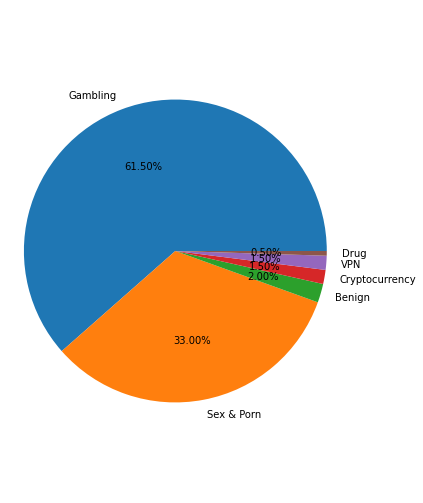

In [4]:
import matplotlib.pyplot as plt

df = pd.read_excel('./Mobile Apps.xlsx', sheet_name='hash')
category_cnt = df['Category'].value_counts().rename_axis('cybercrime type').reset_index(name='occurence')
display(category_cnt)

plt.figure(figsize=(6,9))
plt.pie(category_cnt['occurence'], labels=category_cnt['cybercrime type'], autopct="%.2f%%")
plt.axis('equal')   


# Types of Mobile Threats

In [5]:
# security vendor analysis

import pandas as pd
from collections import defaultdict

vendor_analyses = defaultdict(set)

for apk_id in vendor_malicious_apks:
    report = apk_vt_reports[apk_id]
    vendors = report['data']['attributes']['last_analysis_results']
    for vendor in vendors:
        if vendors[vendor]['result'] != None:
            analysis = f"[{vendor}] {vendors[vendor]['result']}"
            vendor_analyses[analysis].add(apk_id)

vendor_analyses_sorted = sorted(vendor_analyses.items(), key = lambda x:len(x[1]), reverse=True)
print(f"There are {len(vendor_analyses)} different security vendor analyses observed.\nAnd the 10 most frequent are listed below.")

pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_rows',100)
df = pd.DataFrame([(k, len(v)) for k, v in vendor_analyses_sorted], columns=['vendor_analysis', 'occurence'])
df.head(10)

There are 73 different security vendor analyses observed.
And the 10 most frequent are listed below.


,vendor_analysis,occurence
0,[Avast-Mobile] Android:Evo-gen [Trj],32
1,[Fortinet] Riskware/PackagingUntrustworthyJiagu!Android,12
2,[Tencent] a.fraud.SCMgeneric,11
3,[Sophos] Android Packed App (PUA),9
4,[ESET-NOD32] a variant of Android/Packed.Jiagu.D potentially unsafe,8
5,[Avira] ANDROID/Malformed.ZIP.Gen,8
6,[Ikarus] PUA.AndroidOS.Jiagu,8
7,[Ikarus] PUA.AndroidOS.DataCollector,7
8,[Google] Detected,7
9,[Cynet] Malicious (score: 99),7


In [6]:
# sandbox 

import pandas as pd
from collections import defaultdict

sandbox_classification = defaultdict(set)

for apk_id in sandbox_malicious_apks:
    report = apk_vt_reports[apk_id]
    # print(json.dumps(report, indent=2))
    malware_classification = report['data']['attributes']['sandbox_verdicts']['Zenbox android']['malware_classification']
    for classification in malware_classification:
        sandbox_classification[classification.lower()].add(apk_id)

sandbox_classification_sorted = sorted(sandbox_classification.items(), key = lambda x:len(x[1]), reverse=True)

print(f"There are {len(sandbox_classification)} malware classification observed.")
df = pd.DataFrame([(k, len(v)) for k, v in sandbox_classification_sorted], columns=['malware classification', 'occurence'])
display(df)


There are 3 malware classification observed.


,malware classification,occurence
0,malware,26
1,trojan,26
2,evader,26


Mapping security vendors' analyses to general categories manully [[reference]](https://securelist.com/mobile-threat-report-2022/108844/)

In [7]:
pd.read_csv('./vendor_analysis_mapping.csv')

,vendor_analysis,category,sub_category
0,[SymantecMobileInsight] AdLibrary:Generisk,Adware,NaN
1,[SymantecMobileInsight] AdLibrary:Jpush,Adware,NaN
2,[DrWeb] Adware.ShareInstall.1.origin,Adware,NaN
3,[K7GW] Adware ( 0059ca381 ),Adware,NaN
4,[Ikarus] PUA.AndroidOS.AdDisplay,Adware,NaN
5,[Avira] ANDROID/Malformed.ZIP.Gen,Malformed,NaN
6,[F-Secure] Malware.ANDROID/Malformed.ZIP.Gen,Malformed,NaN
7,[McAfee-GW-Edition] Artemis!6EB81FFD8794,Malware,NaN
8,[McAfee] Artemis!6EB81FFD8794,Malware,NaN
9,[McAfee] Artemis!F51184FEEB17,Malware,NaN


With the addition of the sandbox classification categories, we ended up with a total of 7 mobile threats:

| Mobile Threats                  |
| ------------------------------- |
| Adware                          |
| Malformed                       |
| Spyware                         |
| Evader                          |
| Malware                         |
| Riskware                        |
| Trojan                          |

**Adware** generates money for the developer by automatically displaying advertisements on your phone screen. The aim is to get you to click on the ad which can also be targeted to your internet searches. 

**Malformed** means that the file has irregularities in its PE header. A malformed PE header is usually a sign of either a corrupt file or a deliberate attempt to camouflage malware.

**Spyware** hides in the background on a mobile device and steals information such as incoming/outgoing SMS messages, incoming/outgoing call logs, contact lists, emails, browser history, and photos. They can also potentially record inputted keystrokes, record anything within the distance of the device’s microphone, secretly take pictures in the background, and track the device’s location using GPS.

**Evader** can recognize if it's inside a sandbox or virtual machine environment. These malware infections don’t execute their malicious code until they’re outside of the controlled environment.

**Malware** is an umbrella term that can be used to cover all manner of threats. There are also some detection codes, such as `Artemis!6EB81FFD8794` from McAfee, `Detected` from Google, `Malicious (score:99)` from Cynet etc. which only indicate that the file is malware but cannot refine its category.

**Riskware** is a general concept referring to legitimate programs that are potentially risky because of software incompatibility, security vulnerability or legal violations. Typically, these programs are not designed to be malicious, but they do have functions that can be used for malicious purposes.

Sub-categories:

| Riskware                        |
| ------------------------------- |
| SMSreg                          |
| DataCollector                   |
| UntrustworthyPackaging          |
| ScamApp                         |
| Wapron                          |
| Resharer                        |
| Other                           |

- **Riskware-SMSreg** make payments (for example by transferring cash to other individuals or paying for mobile service subscriptions) by sending text messages without explicitly notifying the user.

- **Riskware-DataCollector** collects or transmits data from the device without the user's knowledge or consent. This could include personal or sensitive information such as location data, contacts, browsing history, or other data that could be used for malicious purposes.

- **Riskware-UntrustworthyPackaging** Some APK hardening tool (like 360-Jiagu), which is commonly used to protect APK files from being reverse engineered and modified, can also be used by malicious actors to hide or obfuscate malicious code.

- **Riskware-ScamApp** is commonly used for fraudulent activities such as sending spam messages, making fraudulent calls, displaying unwanted ads and so on. 

- **Riskware-Wapron** Members of this family target victims’ mobile accounts, in particular by sending chargeable text messages on behalf of the victim as payment for supposedly viewing porn.

- **Riskware-Resharer** This family is noted for its self-propagation through posting information about itself on various sites and mailing it to the victim’s contacts.

**Trojan** disguises itself as a legitimate app. Once the user opens this app, the malware is activated. A trojan infects the operating system by deactivating other apps or freezing the device itself. 

Sub-categories:

| Trojan                          |
| --------------------------------|
| Downloader                      |
| Dropper                         |
| Spy                             |
| Other                           |

- **Trojan-Downloader** secretly downloads malicious files from a remote server, then installs and executes the files.

- **Trojan-Dropper** contains malicious apps in Android/Trojan Dropper's Assets Directory, then it drops and installs them without letting user know.

- **Trojan-Spy** secretly installs spy programs or keylogger programs, monitoring activities on the device and stealing content from it.

,mobile_threat,occurence
0,malware,40
1,trojan,68
2,evader,26
3,adware,12
4,riskware,52
5,malformed,8
6,spyware,4


(-1.111816435830962,
 1.1005626896217067,
 -1.1321340256210874,
 1.1160192479157607)

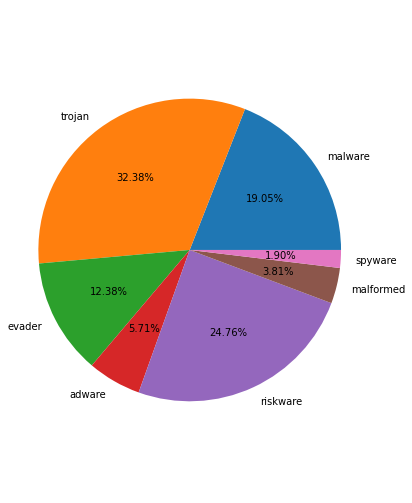

In [8]:
# Distribution of Mobile Threats
import csv
import matplotlib.pyplot as plt

va_mapping = dict()
with open("./vendor_analysis_mapping.csv", "r", encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file)
    next(reader)
    for row in reader:
        va_mapping[row[0]] = row[1].lower()

mobile_threats_to_apks = defaultdict(set)
malicious_apks_types = defaultdict(set)
for apk in malicious_apks:
    for va in vendor_analyses:
        if apk in vendor_analyses[va]:
            mobile_threats_to_apks[va_mapping[va]].add(apk)
            malicious_apks_types[apk].add(va_mapping[va])
    for sd in sandbox_classification:
        if apk in sandbox_classification[sd]:
            mobile_threats_to_apks[sd].add(apk)
            malicious_apks_types[apk].add(sd)

df = pd.DataFrame([(k, len(mobile_threats_to_apks[k])) for k in mobile_threats_to_apks], columns=['mobile_threat', 'occurence'])
display(df)
# df.groupby(['mobile_threat']).sum().plot(kind='pie', y='occurence', autopct='%1.0f%%', title='Distribution of Mobile Threats')

plt.figure(figsize=(6,9))
plt.pie(df['occurence'], labels=df['mobile_threat'], autopct="%.2f%%")
plt.axis('equal')                                         


,riskware,occurence
0,datacollector,7
1,scamapp,12
2,other,22
3,untrustworthypackaging,15
4,resharer,1
5,smsreg,1
6,wapron,1


(-1.1094998558006892,
 1.100452374085747,
 -1.1070996023018893,
 1.123889777342822)

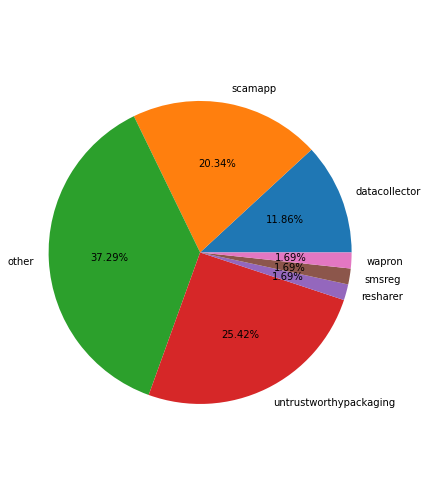

In [9]:
# Distribution of Riskware
import csv

riskware_mapping = dict()
with open("./vendor_analysis_mapping.csv", "r", encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file)
    next(reader)
    for row in reader:
        if row[1] == 'Riskware':
            riskware_mapping[row[0]] = row[2].lower()

riskware_to_apks = defaultdict(set)
for apk in mobile_threats_to_apks['riskware']:
    for va in vendor_analyses:
        if apk in vendor_analyses[va] and va_mapping[va] == 'riskware':
            riskware_to_apks[riskware_mapping[va]].add(apk)

df = pd.DataFrame([(k, len(riskware_to_apks[k])) for k in riskware_to_apks], columns=['riskware', 'occurence'])
display(df)
# df.groupby(['riskware']).sum().plot(kind='pie', y='occurence', autopct='%1.0f%%', title='Distribution of Riskware')

plt.figure(figsize=(6,9))
plt.pie(df['occurence'], labels=df['riskware'], autopct="%.2f%%")
plt.axis('equal')                                         

,trojan,occurence
0,other,51
1,downloader,1
2,dropper,6
3,spy,1


(-1.1063636877276648,
 1.1003030327489365,
 -1.1042335514803419,
 1.1068221700799972)

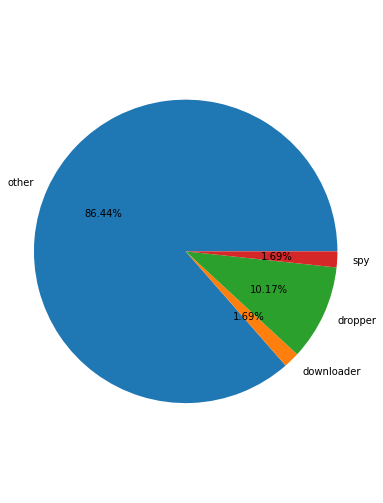

In [10]:
# Distribution of Trojan
import csv

trojan_mapping = dict()
with open("./vendor_analysis_mapping.csv", "r", encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file)
    next(reader)
    for row in reader:
        if row[1] == 'Trojan':
            trojan_mapping[row[0]] = row[2].lower()

trojan_to_apks = defaultdict(set)
for apk in mobile_threats_to_apks['trojan']:
    for va in vendor_analyses:
        if apk in vendor_analyses[va] and va_mapping[va] == 'trojan':
            trojan_to_apks[trojan_mapping[va]].add(apk)

df = pd.DataFrame([(k, len(trojan_to_apks[k])) for k in trojan_to_apks], columns=['trojan', 'occurence'])
display(df)
# df.groupby(['trojan']).sum().plot(kind='pie', y='occurence', autopct='%1.0f%%', title='Distribution of Trojan')

plt.figure(figsize=(6,9))
plt.pie(df['occurence'], labels=df['trojan'], autopct="%.2f%%")
plt.axis('equal')                                         

In [11]:
# Save results to `app_analysis_results.csv`
import csv   

df = pd.read_excel('./Mobile Apps.xlsx', sheet_name='hash')

results = []
for row in df.iterrows():
    domain = row[1][0]
    landing_url = row[1][1]
    download_url = row[1][2]
    path = row[1][3]
    sha_256 = row[1][4]
    category = row[1][5]
    is_new = True if sha_256 in new_apks else False
    is_malicious = True if sha_256 in malicious_apks else False
    threat_type = malicious_apks_types[sha_256] if is_malicious else ''
    results.append([domain, landing_url, download_url, path, sha_256, category, is_new, is_malicious, threat_type])

with open("./app_analysis_results.csv", "w", encoding="utf-8", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Domain', 'Landing URL', 'Download URL', 'Path', 'SHA-256', 'Category', 'is_new', 'is_malicious', 'Threat Type'])
    writer.writerows(results)

pd.read_csv('./app_analysis_results.csv').head(20)


,Domain,Landing URL,Download URL,Path,SHA-256,Category,is_new,is_malicious,Threat Type
0,6park.com,https://www.6park.com/main.shtml,https://home.6park.com/client/6park.apk,/data2/sangyiwu/Mobile_Apps/apk_files/6park.apk,f1fb03348b02b647b0bad1fde4be3555b374de6dc7c320be46c5fae1c827ba6f,Benign,False,False,NaN
1,www.djyule.com,https://sj.djyule.com/download.htm,https://www.djyule.com/djbox_upapk/djbox6_19_11_138.apk,/data2/sangyiwu/Mobile_Apps/apk_files/djbox6_19_11_138.apk,24f56817b2a3ec8217cb257ad8ca8311be960276e5994f0bccf85c60fa3b2994,Benign,False,True,"{'riskware', 'trojan'}"
2,2345.com,https://m.2345.com/app.htm,https://dl.2345.com/2345mobile/2345Daohang_12.0.1.apk,/data2/sangyiwu/Mobile_Apps/apk_files/2345Daohang_12.0.1.apk,6aae24dfb1c9cf1964fb63013b288ccf1cc9098aa0ce04099ec58ee3885ab681,Benign,True,True,"{'evader', 'adware', 'malware', 'trojan'}"
3,ixigua.com,https://m.ixigua.com/,https://lf9-apk.ugapk.cn/package/apk/video_article/1008_734/video_article_xigua_m_lv_1222_and_v1...,/data2/sangyiwu/Mobile_Apps/apk_files/video_article_xigua_m_lv_1222_and_v1008_734_e9c9_167706477...,b3fea55e9e235396f9b5dc3e653a8fda416b23d3a2b97499b6dc84a18d40e147,Benign,True,False,NaN
4,8v.com,https://download.8vtrade.com/,https://static.aws-s1.com/app/8v_1_1_4.apk,/data2/sangyiwu/Mobile_Apps/apk_files/8v_1_1_4.apk,8a6d3bb0a5f6b2a918b3cad053aa0309c6eb492b6f242e57762d5070b5e430bd,Cryptocurrency,True,False,NaN
5,www.huobipro-jyptgw.com,https://m.huobi.com/zh-cn/download,https://global-prd-client-download.oss-cn-hongkong.aliyuncs.com/huobi90701c0.apk?v=1677758704056,/data2/sangyiwu/Mobile_Apps/apk_files/huobi90701c0.apk,4a8c47f7c012593412947a907cd262159016ac1242e543b194bd3621a1ce1884,Cryptocurrency,True,False,NaN
6,www.huobipro-jyptgw.com,https://www.huobi.com/zh-cn/download/#exchange,https://global-prd-client-download.oss-cn-hongkong.aliyuncs.com/huobi90601c0.apk?v=1676624520071,/data2/sangyiwu/Mobile_Apps/apk_files/huobi90601c0.apk,265a5ab992febd43f38aa6dd0aa593c3bea8fbbbcefc865b93ee945d5b9cdb6e,Cryptocurrency,True,False,NaN
7,v77.kr,https://bman7.xyz/,https://bman7.xyz/download/powerman.apk,/data2/sangyiwu/Mobile_Apps/apk_files/powerman.apk,939c654d64ede7f66cab6011997865cae6108a3d07d793d3f5067334cb5eb4de,Drug,False,False,NaN
8,92527.org,https://colorchat.app/,https://colorchat.app/105/105.apk,/data2/sangyiwu/Mobile_Apps/apk_files/105.apk,60917872d6ba95bd0338baae5246ebcac2daa4becb9314e5d66f38f8848d3ffd,Gambling,False,False,NaN
9,r.vip,https://www.aa.vip/home/game,https://5xyhts-135-ppp.s3.ap-east-1.amazonaws.com/cocos/download/135_en_normal_3.2.0.apk?X-Amz-A...,/data2/sangyiwu/Mobile_Apps/apk_files/135_en_normal_3.2.0.apk,a59d3f94ef53f0424e3d34279b99b7762a0598fb763fd7a7c26aa67668d92a2a,Gambling,True,True,"{'evader', 'malware', 'trojan'}"


## Information related to some security vendor analyses

### [Avast-Mobile] Android:Evo-gen [Trj]	

Android:Evo-gen [Trj] is a heuristic detection designed to generically detect a Trojan Horse.

Typical behavior for Trojans like Android:Evo-gen [Trj] is one or more of the following:
- Download and install other malware.
- Use your computer for click fraud.
- Record your keystrokes and the sites you visit.
- Send information about your PC, including usernames and browsing history, to a remote malicious hacker.
- Give remote access to your PC.
- Advertising banners are injected with the web pages that you are visiting.
- Random web page text is turned into hyperlinks.
- Browser popups appear which recommend fake updates or other software.

### [Fortinet] Riskware/PackagingUntrustworthyJiagu!Android

[Fortinet] Riskware/PackagingUntrustworthyJiagu!Android refers to a type of software which may not necessarily be malware, but could pose some security risks or vulnerabilities. The APK file may have been packaged using an untrustworthy method and "Jiagu" refers to the specific APK hardening tool being used.

### [Tencent] a.fraud.SCMgeneric	

a.fraud.SCMgeneric is a detection name for a malicious code by Tencent antivirus software. 

This code refers to a type of malicious software that is commonly used for fraudulent activities such as sending spam messages, making fraudulent calls, displaying unwanted ads, and so on. It can install on the user's device without their knowledge and potentially compromise their privacy and security. This malware may collect personal information, intercept messages, monitor user contacts and location, among other activities, resulting in user privacy being breached.

### [Sophos] Android Packed App (PUA)	

Some apps, while not strictly defined as malware, exhibit sketchy behaviors that may also threaten user privacy and security, which we call potentially unwanted apps (PUA).

Many PUAs contain adware, collect user data unnecessarily, or deceive users with phony malware pop-ups and other scammy behavior.

### [ESET-NOD32] a variant of Android/Packed.Jiagu.D potentially unsafe

Android/Packed.Jiagu.D refers to a specific type of APK hardening tool called Jiagu, which is commonly used to protect APK files from being reverse engineered and modified. However, this tool can also be used by malicious actors to hide or obfuscate malicious code.

Same as [Fortinet] Riskware/PackagingUntrustworthyJiagu!Android

### [Avira] ANDROID/Malformed.ZIP.Gen

Malformed.ZIP suggests that the file is a ZIP archive that has been created or modified in an incorrect or abnormal way. So the file may contain some security risks or vulnerabilities, such as hidden or obfuscated malicious code or other harmful content.

### [Ikarus] PUA.AndroidOS.Jiagu

Jiagu is a type of APK hardening tool that can be used to protect APK files from being reverse-engineered or modified. However, it can also be used by malicious actors to hide or obfuscate malicious code.

Same as [Fortinet] Riskware/PackagingUntrustworthyJiagu!Android and [ESET-NOD32] a variant of Android/Packed.Jiagu.D potentially unsafe

### [Ikarus] PUA.AndroidOS.DataCollector

DataCollector suggests that the application may collect or transmit data from the device without the user's knowledge or consent. This could include personal or sensitive information such as location data, contacts, browsing history, or other data that could be used for malicious purposes.

### [Ikarus] Trojan-Dropper.AndroidOS.Agent

Android/Trojan.Dropper is a malicious app that contains additional malicious app(s) within its payload. The Android/Trojan.Dropper will install the additional malicious app(s) onto an infected mobile device.

On the Android OS, most often the malicious app(s) to be dropped is/are contained within the Android/Trojan.Dropper’s Assets Directory.  The Assets Directory is an optional directory that can be added to an APK to store raw asset files. In the case of a Mobile Trojan Dropper, it contains a malicious APK(s) to be dropped and installed.

### [Avast-Mobile] APK:CRepMalware [PUP]	

The term "PUP" indicates that the program may not necessarily be harmful, but could still pose some security risks or potentially unwanted behavior.

PUPs use the mobile platform and trusting nature of users to install an app which might have cool functionality but comes bundled with unwanted features such as draining the battery, leaking data, and aggressive advertising. These apps aren't necessarily malicious but users might want to reconsider installing due to performance hits or bad reputation.

### [SymantecMobileInsight] AdLibrary:Generisk	

The app may contain infomation-stealing ad libraries from third-party advertising networks. 
